# Проект "Автоматизация коммуникаций"
## Задача

Ежедневно Wildberries получает огромное количество различных обращений клиентов по различным вопросам и из разных источников. Многие из этих обращений обрабатываются при помощи автоматизированных систем. Вам предстоит создать вопросно-ответную систему, которая генерирует ответ на обращения в техподдержку для менеджеров ПВЗ.

Вам будут доступны данные в виде истории вопросов и ответов на них, а также база знаний в виде документов, в которых содержится информация, регламентирующая работу менеджера на ПВЗ и описывающая многие бизнес-
процессы.

## 3. Baseline
На данном этапе вам необходимо:
- Выбрать метрику оценки качества и обосновать выбор
- Разработать baseline (может быть несколько алгоритмов)
- Реализовать выбранное решение/я
- Протестировать работу baseline
- Выбрать итоговое решение для дальнейшей оптимизации и обосновать выбор

Сокращения:\
**АС** - Автоматизированная система

### **Recap предыдущего этапа**
---

#### **Решения**

Основная идея - использовать более сложные модели, чтобы более точно выявлять структуры и паттерны в данных.

Алгоритмы и инструкции для каждого этапа:
1. Формирование обучающих данных и обучение моделей:\
  Предлагается использовать предобученные модели\
  Предложения по улучшению в [статье](https://habr.com/ru/articles/791966/) (файнтюниг моделей)
2. Обработка запроса:
  - Очистка текста (открытые библиотеки);
  - Проверить модели ChatGPT, LangChan, Semantic Kernel, ClusterLLM, saiga_mistral_7b_lora, Mistral-7B-OpenOrca на данных "Вопрос-ответ"
3. Поиск эталонного ответа в данных "Вопрос-ответ":
  - Использовать ANN-алгоритм ([Faiss](https://github.com/facebookresearch/faiss), [Azure Cognitive Search](https://azure.microsoft.com/en-us/products/ai-services/ai-search/)) для поиска схожего вопроса и соответствующего ответа для него;
  - Пропустить эталонный ответ через трансформерный алгоритм для задачи NER (открытые библиотеки,  [benchmark](https://paperswithcode.com/task/named-entity-recognition-ner));
4. Поиск документов в базе знаний:
  - Проверить гипотезу о тематическом моделировании с помощью BigARTM + LLM;
  - Пропустить документы через трансформер для задачи NER (открытые библиотеки,  [benchmark](https://paperswithcode.com/task/named-entity-recognition-ner));
  - Проверить ANN-алгоритм для поиска документов в базе знаний  ([Faiss](https://github.com/facebookresearch/faiss), [Azure Cognitive Search](https://azure.microsoft.com/en-us/products/ai-services/ai-search/))(одиночный способ или гибридный с NER или ТМ).
5. Генерация ответа:
  - Проверить модели ChatGPT, LangChan, Semantic Kernel, saiga_mistral_7b_lora, Mistral-7B-OpenOrca;


**Замечание:** \
Предложены возможные алгоритмы для каждого этапа, однако, для baseline будет реализована более простая система. Усложнения на шаге оптимизации.

#### **Архитектура RAG-системы**

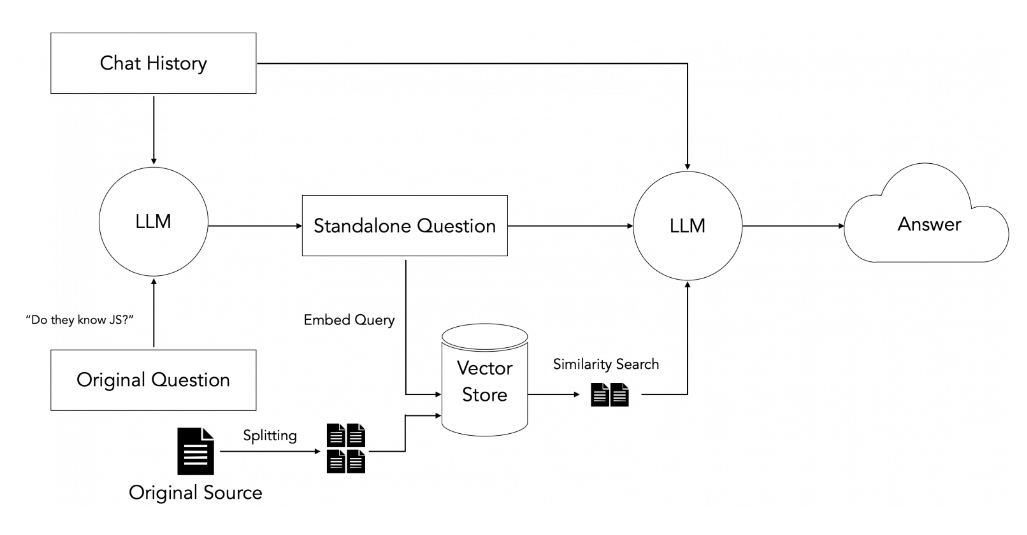

[Cтатья](https://habr.com/ru/companies/wunderfund/articles/779748/)

#### **Метрики оценки**

Валидация пайплайна RAG-системы:
  - Фреймворк [RAGAS](https://towardsdatascience.com/evaluating-rag-applications-with-ragas-81d67b0ee31a)
  - Применение данных "Вопрос-ответ" для валидации

Также:
- Оценить качество работы алгоритмов для задачи тематического моделирования;
- Оценить качество формируемых эмбеддингов на задаче кластеризации, сформировать векторные представления;

### **Baseline**
---

### Разработка baseline'a

На предыдущем этапе были проанализированы возможные алгоритмы и решения.

Для бейзлайна выбраны следующие модели:
- Векторизация текстов (модель): RuBert
- Генерация ответов (модель): saiga_mistral_7b_lora
- Векторный поиск: Faiss

Pipeline:
1. Предобработка запроса и векторазиция
2. Векторный поиск в базе QA и базе знаний по запросу релеватных вопросов и чанков соответственно.
3. (для QA) Для найденного эталонного вопроса выбрать соответствующий эталонный ответ, векторизовать
4. Векторный поиск в базе знаний по эталонному ответу чанков.
5. Агрегировать полученные результаты (промпты) и сгенерировать ответ.

#### *Освобождение памяти GPU

In [1]:
!pip install GPUtil > None

In [2]:
from GPUtil import showUtilization as gpu_usage

gpu_usage()          

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |


#### **Ход работы**

In [1]:
# установка библиотек
!pip install peft
!conda install -c pytorch faiss-gpu -y
!pip install -q -U bitsandbytes accelerate transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 2.6 MB/s eta 0:00:0000:010:01
Retrieving notices: ...working... done
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.5.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - faiss-gpu


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    faiss-gpu-1.8.0            |py3.10_h4c7d538_0_cuda12.1.1         5.0 MB  pytorch
    libfaiss-1.8.0             |h046e95b_0_cuda12.1.1       268.9 MB  pytorch
    openssl-3.3.0              |       hd590300_0         2.8 MB  conda-forge
    ------------------------------------------------------------
 

In [2]:
!pip install rouge
!pip install nltk==3.8.1

import nltk
download_dir = '/kaggle/working/nltk_data'
nltk.download('wordnet', download_dir=download_dir)
nltk.data.path.append(download_dir)

!unzip /kaggle/working/nltk_data/corpora/wordnet.zip -d /kaggle/working/nltk_data/corpora/ -y

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.


[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...


Archive:  /kaggle/working/nltk_data/corpora/wordnet.zip
caution: filename not matched:  -y


In [3]:
# подключение библиотек
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import gc
import torch
import torch.nn.functional as F
import transformers
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
import faiss

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from nltk import word_tokenize
from rouge import Rouge 

In [4]:
# глобальные переменные конфигурации
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LLM_MODEL_NAME = "IlyaGusev/saiga_mistral_7b"
LLM_DEFAULT_MESSAGE_TEMPLATE = "<s>{role}\n{content}</s>"
LLM_DEFAULT_RESPONSE_TEMPLATE = "<s>bot\n"
LLM_DEFAULT_SYSTEM_PROMPT = "Ты — Сайга, русскоязычный автоматический ассистент. Ты разговариваешь с людьми и помогаешь им."
EMBEDDER_MODEL_NAME = "DeepPavlov/rubert-base-cased"

In [5]:
# очистка мусора в тексте
def clean_html(raw):
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    raw = re.sub(cleanr, ' ', raw)
    raw = re.sub('< nt >', '. ', raw)
    cleantext = re.sub("\\n", '. ', raw)
    return cleantext

# метрики качества генерации
def calculate_bleu(candidate, reference):
    '''
    candidate, reference: generated and ground-truth sentences
    '''
    reference = word_tokenize(reference)
    candidate = word_tokenize(candidate)
    score = sentence_bleu(reference, candidate)
    return score


def calculate_rouge(candidate, reference):
    '''
    candidate, reference: generated and ground-truth sentences
    '''
    rouge = Rouge()
    scores = rouge.get_scores(candidate, reference)
    return scores


def calculate_meteor(candidate, reference):
  '''
  candidate, reference: tokenized list of words in the sentence
  '''
  reference = word_tokenize(reference)
  candidate = word_tokenize(candidate)
  score = round(meteor_score([candidate],reference), 4)
  return score

In [6]:
# Класс истории диалога
class Conversation:
    def __init__(
        self,
        message_template=LLM_DEFAULT_MESSAGE_TEMPLATE,
        system_prompt=LLM_DEFAULT_SYSTEM_PROMPT,
        response_template=LLM_DEFAULT_RESPONSE_TEMPLATE
    ):
        self.message_template = message_template
        self.response_template = response_template
        self.messages = [{
            "role": "system",
            "content": system_prompt
        }]

    def add_user_message(self, message):
        self.messages.append({
            "role": "user",
            "content": message
        })

    def add_bot_message(self, message):
        self.messages.append({
            "role": "bot",
            "content": message
        })

    def get_prompt(self, tokenizer):
        final_text = ""
        for message in self.messages:
            message_text = self.message_template.format(**message)
            final_text += message_text
        final_text += LLM_DEFAULT_RESPONSE_TEMPLATE
        return final_text.strip()


In [7]:
# Класс RAG-системы
class RAG:    
    def __average_pool(self, last_hidden_states, attention_mask):
        """
        Функция, возвращает эмбеддинги с последнего слоя
        """
        last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
        return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]
    
    def __init_embedder(self):
        """
        Инициализация LLM-модели для получения векторных представлений текстов
        """
        self.embedder_model = transformers.AutoModel.from_pretrained(EMBEDDER_MODEL_NAME)
        self.embedder_tokenizer = transformers.AutoTokenizer.from_pretrained(EMBEDDER_MODEL_NAME)
        self.embedder_model.to(self.device)
        self.emb_dim = 768
        
    def __init_llm_generator(self):
        """
        Инициализация LLM-модели для генерации текста
        """
        self.llm_config = PeftConfig.from_pretrained(LLM_MODEL_NAME)
        self.llm_model = AutoModelForCausalLM.from_pretrained(
            self.llm_config.base_model_name_or_path,
            load_in_8bit=True,
            torch_dtype=torch.float16,
            device_map="auto"
        )
        self.llm_model = PeftModel.from_pretrained(
            self.llm_model,
            LLM_MODEL_NAME,
            torch_dtype=torch.float16
        )
        self.llm_model.eval()
        self.llm_tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL_NAME, use_fast=False)
        self.generation_config = GenerationConfig.from_pretrained(LLM_MODEL_NAME)
    
    def __init__(self, knowledge_base, qa_pairs, device):
        """
        Конструктор класса RAG
        """
        self.device = device
        
        # инициализация моделей
        self.__init_embedder()
        self.__init_llm_generator()

        # инициализация диалога
        self.conversation = Conversation()
        
        # сохранение данных
        self.knw_base = knowledge_base
        self.qa_base = qa_pairs

        # векторизация базы знаний и создание индекса
        chunk_embs = self.vectorize(self.knw_base['chunk'])
        self.chunk_index = faiss.IndexFlatIP(self.emb_dim)
        self.chunk_index.add(chunk_embs)

        # векторизация вопросов и создание индекса
        ques_embs = self.vectorize(self.qa_base['question'])
        self.ques_index = faiss.IndexFlatIP(self.emb_dim)
        self.ques_index.add(ques_embs)
    
    @torch.no_grad()
    def vectorize(self, data):
        """
        Получение векторных представлений текстов
        """
        data_vectorized = np.zeros((len(data), self.emb_dim))
        for index, sentence in enumerate(data):
            batch_dict = self.embedder_tokenizer(sentence,
                                      max_length=512,
                                      padding=True,
                                      truncation=True,
                                      return_tensors='pt').to(self.device)
            outputs = self.embedder_model(**batch_dict)
            embeddings = self.__average_pool(outputs.last_hidden_state,
                                             batch_dict['attention_mask'])
            data_vectorized[index] = embeddings.cpu().detach().numpy()
        return data_vectorized
    
    def generate(self, input):
        """
        Функция, генерирует ответ на запрос пользователя
        """
        self.conversation.add_user_message(input)
        
        prompt = self.conversation.get_prompt(self.llm_tokenizer)
        data = self.llm_tokenizer(prompt, return_tensors="pt")
        data = {k: v.to(self.llm_model.device) for k, v in data.items()}
        output_ids = self.llm_model.generate(
            **data,
            generation_config=self.generation_config
        )[0]
        output_ids = output_ids[len(data["input_ids"][0]):]
        output = self.llm_tokenizer.decode(output_ids, skip_special_tokens=True).strip()
        
        self.conversation.add_bot_message(output)
        return output
    
    def ask(self, user_request, k_neighbours=(15, 15)):
        """
        Функция поиска чанков и генерации ответа на запрос пользователя
        """
        user_request = clean_html(user_request)
        user_request_vector = self.vectorize([user_request])
        
        # поиск чанков по запросу
        _, chunk_indexes_by_req = self.chunk_index.search(user_request_vector, k_neighbours[1])

        # поиск чанков по эталону
        _, ques_indexes_by_req = self.ques_index.search(user_request_vector, k_neighbours[0])
        standard_answer = self.qa_base['answer'].iloc[ques_indexes_by_req[0][0]]
        standard_answer_vector = self.vectorize([standard_answer])
        _, chunk_indexes_by_st = self.chunk_index.search(standard_answer_vector, k_neighbours[1])
        
        # генерация ответа         
        answer_by_req = self.knw_base['chunk'].iloc[chunk_indexes_by_req[0][0]]
        answer_by_st = self.knw_base['chunk'].iloc[chunk_indexes_by_st[0][0]]
        
        input = f"""
            вопрос: {user_request}
            промпты: {standard_answer}, {answer_by_req}, {answer_by_st}
        """
        output = self.generate(input)
        
        return output 
    
    def clean_history(self):
        """
        Функция для очистки истории сообщений
        """
        del self.conversation
        self.conversation = Conversation()
    
    def __del__(self):
        """
        Деструктор, удаляет LLM-модели из памяти GPU
        """
        variables = [self.embedder_model, self.llm_model]
        for var in variables:
            del var
            gc.collect()
            torch.cuda.empty_cache()

### Чтение данных

In [8]:
knowledge_base = pd.read_excel('/kaggle/input/rag-datasets/knowledge_base.xlsx')
qa_pairs = pd.read_excel('/kaggle/input/rag-datasets/QA_pairs.xlsx')

In [9]:
# Длины предложений базы знаний
knowledge_base_lengths = knowledge_base.copy()
knowledge_base_lengths['chunk_len'] = knowledge_base_lengths['chunk'].apply(lambda x: len(x.split(' ')))
knowledge_base_lengths.drop(columns=['id','document_id', 'part_id'], inplace=True)

In [10]:
# удаление первых неинформативных чанков
indexes_to_del = knowledge_base_lengths.sort_values(by='chunk_len').head(12).index
knowledge_base.drop(index=indexes_to_del, inplace=True)

### Предобработка

In [11]:
# удаление дублей
knowledge_base = knowledge_base[~knowledge_base[['chunk', 'document_id', 'part_id']].duplicated()]
qa_pairs = qa_pairs[~qa_pairs[['question', 'answer']].duplicated()]

In [12]:
# удаление мусора
qa_pairs['question'] = qa_pairs['question'].apply(lambda text_data: clean_html(text_data.lower()))
qa_pairs['answer'] = qa_pairs['answer'].apply(lambda text_data: clean_html(text_data.lower()))
knowledge_base['chunk'] = knowledge_base['chunk'].apply(lambda text_data: clean_html(text_data.lower()))

### RAG-система

In [13]:
rag = RAG(knowledge_base, qa_pairs, device)

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequence

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/623 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/54.6M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


generation_config.json:   0%|          | 0.00/265 [00:00<?, ?B/s]

In [14]:
print(rag.ask('Как оформить возврат?'))

2024-05-15 16:59:30.757894: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 16:59:30.758010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 16:59:30.871117: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Возврат товара осуществляется через интернет-магазин или магазин, где был куплен товар. Для оформления возврата вам нужно будет предоставить следующие документы:

1. Акт о возврате товара (заполненный и подписанный).
2. Комментарий к акту о возврате, где указывается причина возврата и состояние товара.
3. Фотографии товара в его текущем состоянии (если это необходимо).
4. Фотографии акта о возврате (если это необходимо).
5. Полученные при покупке товара документы (паспорт, счет-фактура, полис страхования и т.д.).
6. Факс или электронное письмо с просьбой о возврате товара.
7. Справка о возврате товара из магазина (если это необходимо).
8. Доказательство оплаты товара (если это необходимо).
9. Справка о возврате товара из магазинной сети (если это необходимо).

После того как вы предоставите все необходимые документы, они будут рассмотрены сотрудниками магазина. Если все будет в порядке, то вам будет предоставлена возможность вернуть товар обратно в магазин.

Если товар был куплен онлай

In [15]:
print(rag.ask('Как добавить сотрудника в черный список?'))

Для добавления сотрудника в черный список, вам нужно будет предоставить следующую информацию:

1. ФИО сотрудника.
2. Номер телефона сотрудника.
3. Электронная почта сотрудника.
4. Причина добавления сотрудника в черный списоk.

После того как вы предоставите все необходные данные, они будут рассмотрены сотрудниками компании. Если все будет в порядке, то сотрудник будет добавлен в черный список.

Черный список - это список сотрудников, которые не имеют права работать в компании. Он используется для того, чтобы предотвратить нежелательную деятельность сотрудников и защитить интересы компании.

Если сотрудник был добавлен в черный список, то он не сможет работать в компании. Если сотрудник хочет вернуться на работу, то он должен обратиться в компанию и объяснить, почему он был добавлен в черный список. Если компания сочтет его объяснения достоверными, то сотрудник может быть удален из черного списка.


**Выводы** \
Разработан baseline и протестирована его работа. Стоит подчеркнуть качество формируемых ответов. Это говорит о том, что идея использования более сложных моделей и стратегия поиска и формирования промптов для генеративной модели, а именно использовать в качестве промптов:
- эталонный ответ
- чанк по эталонному ответу
- чанк по запросу пользователя\
оправдали себя

Однако, скорость генерации ответа желает лучшего.

### Валидация

Валидация состоит из следующих моментов:
1. Оценка векторных представлений (RuBert)
    - визуальный анализ
    - качество на решаемой задаче
2. Оценка ретривера (Faiss (QA), Faiss (knowledge base))
3. Оценка генерируемого ответа (saiga_mistral_7b_lora)
    - Rouge
    - BLEU
    - LSA
    - BERTScore
    - METEOR
    - Self-BLEU
    - TER
4. Оценка Rag-pipeline'a
    - Context precision 
    - Context recall
    - Faithfulness 
    - Answer relevancy\
  Фреймворк [RAGAS](https://towardsdatascience.com/evaluating-rag-applications-with-ragas-81d67b0ee31a)\
  Применение данных "Вопрос-ответ" для валидации

#### Векторные представления


Формируемые моделью векторные представления как правило оцениваются визуально или в рамках решаемой задачи.\
На этапе анализа данных были визаулизированы векторные простраства, получаемые RuBert после векторизации баз QA и knowledge_base.
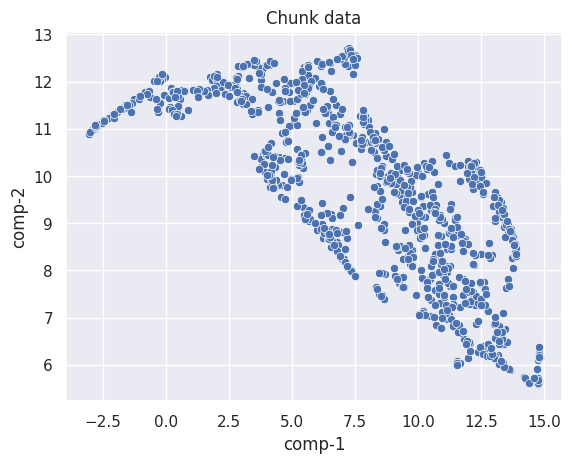\
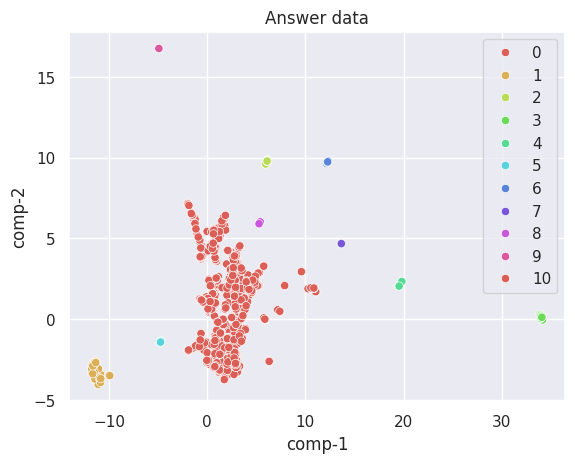\
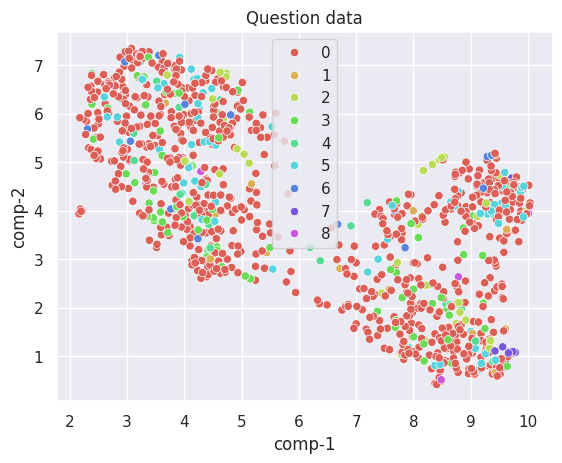

**Выводы**\
Визуально векторные представления не разделяются на кластеры, однако точки не формируют одно облако точек, а представляют сложную форму. При этом стоит заметить, что точки в разных частях графика имеют различный семантический смысл. Таким образом, вектора плавно перетекают из одного сематического смысла в другой. Это может быть связано по нескольким причинам:
- плохое качество данных
- специфика данных, LLM-модель не способна четко различать данные

#### Оценка генерируемого ответа

Наша задача - провалидировать LLM-модель, дополненную информацией из базы знаний

Рассматриваются 3 метрики:
- Rouge: Recall Oriented Understudy for Gisting Evaluation

    Метрика основана на вычислении синтаксического перекрытия между сгенерированным текстом и эталоном.\
    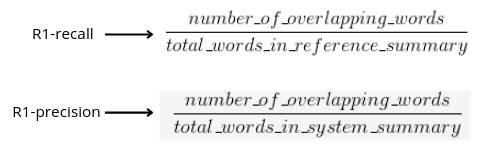

    Rouge-1, Rouge-2, Rouge-L и Rouge-S — некоторые часто вычисляемые числа.
        - Rouge-1 вычисляет перекрытие униграмм (отдельного слова) между фрагментами текстов. 
        - Rouge-2 вычисляет перекрытие биграмм (пар слов). 
        - Rouge-L вычисляет перекрытие самых длинных и одновременно встречающихся в последовательности n-грамм.
        - Rouge-S вычисляет перекрытие Skip - биграммы (любой пары слов в порядке их предложений).
    
    
- BLEU : Bilingual Evaluation Understudy Score

    BLEU — метрика для сравнения моделей в области NLG, ориентированная на precision, которая рассчитывает n-граммное перекрытие эталонного и сгенерированного текстов. Это перекрытие n-грамм означает, что схема оценки не зависит от позиции слова, за исключением терминологических ассоциаций n-грамм. В BLEU следует отметить одну вещь: существует штраф за краткость, то есть штраф, применяемый, когда сгенерированный текст слишком мал по сравнению с целевым текстом.
    
    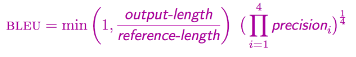

- METEOR: Metric for Evaluation of Translation with Explicit Ordering

    Имеет некоторые очевидные преимущества по сравнению с метрикой BLEU (популярной, когда дело доходит до оценки производительности систем машинного перевода), которая фокусируется на том, чтобы в основном отразить аспект точности генерации по сравнению с эталоном. METEOR, с другой стороны, основан на идее вычисления среднего гармонического значения униграмм precision и recall, где recall придается больший вес, чем precision. Придание большего значения recall позволяет нам лучше понять, какую часть эталона мы создали как часть вывода в процессе генерации.
    
    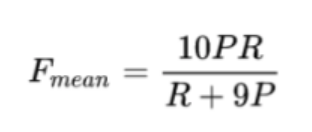
    
[Статья](https://blog.paperspace.com/automated-metrics-for-evaluating-generated-text/)

In [35]:
df_test = qa_pairs.sample(20)[['question', 'answer']]
df_test

,question,answer
2328,в течение какого времени рассматривают тикет о...,все тикеты рассматриваются в порядке общей оче...
3075,"пожалуйста, возьмите в работу, уже всю сумму с...",все тикеты рассматриваются в порядке общей оче...
5280,не могу добавить адрес для нового пвз,"если возникли вопросы при открытии пвз, то обр..."
3190,почему нет тебя для создания тикета баланс?,"чтобы создать тикет ""баланс"", выберите тему ти..."
5772,можно продлить срок хранения клиенту?,"нет, срок хранения товаров на пвз составляет 1..."
4301,где найти раздел доставки?,статистика находится в личном кабинете слава в...
2966,рейтинг 4.99 премия,доплата за рейтинг поступает автоматически на ...
4735,как внести взнос для активации?,единоразовый взнос при регистрации собственник...
2565,"если парик мерили и решили вернуть, можно ли п...",от парика можно отказаться в пвз до проведения...
5391,если пвз 30кв.м,"в городах миллионниках (москва, санкт-петербур..."


In [36]:
candidates = []
references = []

for index, row in df_test.iterrows():
    candidates.append(rag.ask(row['question']))
    references.append(row['answer'])
    rag.clean_history()

In [37]:
for ref, cand in zip(references[:10], candidates[:10]):
    print("ЭТАЛОН:", ref)
    print()
    print("ГЕНЕРАЦИЯ:", cand)
    print('---'*100)

ЭТАЛОН: все тикеты рассматриваются в порядке общей очереди

ГЕНЕРАЦИЯ: Рассмотрение тикетов о неуплате зависит от многих факторов, таких как объем обращений, время суток и т.д. Однако, общий срок рассмотрения тикетов обычно составляет от нескольких часов до нескольких дней.

Чтобы создать заявку на проверку брака, необходимо следующие действия:

1. Обратитесь в службу поддержки Wildberry.
2. Укажите, что вы хотите создать заявку на проверку брака.
3. Предоставьте необходимые данные, такие как номер заказа, дата выдачи и т.д.
4. Получите ответ от службы поддержки о том, как продолжить процесс.

Если вы столкнулись с проблемой, связанной с Wildberry, вы можете связаться с ними по следующим способам:

1. Позвоните по телефону, указанному на их официальном сайте.
2. Отправьте письмо на адрес электронной почты, указанный на их сайте.
3. Напишите в чат на их официальном сайте.

Однако, стоит учесть, что Wildberry может быть занятой и может отвечать на ваши вопросы в течение некоторого времен

In [38]:
blue_data = np.zeros(df_test.shape[0])
rouge1_data, rouge2_data, rougel_data = [], [], []
meteor_data = np.zeros(df_test.shape[0])

for index, (ref, cand) in enumerate(zip(references, candidates)):
    blue_data[index] = calculate_bleu(cand, ref)
    rouge_data = calculate_rouge(cand, ref)[0]
    rouge1_data.append(rouge_data['rouge-1'])
    rouge2_data.append(rouge_data['rouge-2'])
    rougel_data.append(rouge_data['rouge-l'])
    meteor_data[index] = calculate_meteor(cand, ref)

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [39]:
rouge1_data = np.array([[item['f'], item['r'], item['p']] for item in rouge1_data])
rouge2_data = np.array([[item['f'], item['r'], item['p']] for item in rouge2_data])
rougel_data = np.array([[item['f'], item['r'], item['p']] for item in rougel_data])

In [40]:
df_metrics = pd.DataFrame(columns=['samples', 'mean metric', 'mediana of metric', 'std of metric', 'coefficient of variation'],
                         data=[[df_test.shape[0], blue_data.mean(), np.median(blue_data), blue_data.std(), blue_data.std() / blue_data.mean()],
                              [df_test.shape[0], rouge1_data.mean(axis=0)[0], np.median(rouge1_data, axis=0)[0], rouge1_data.std(axis=0)[0], rouge1_data.std(axis=0)[0] / rouge1_data.mean(axis=0)[0]],
                              [df_test.shape[0], rouge1_data.mean(axis=0)[1], np.median(rouge1_data, axis=0)[1], rouge1_data.std(axis=0)[1], rouge1_data.std(axis=0)[1] / rouge1_data.mean(axis=0)[1]],
                              [df_test.shape[0], rouge1_data.mean(axis=0)[2], np.median(rouge1_data, axis=0)[2], rouge1_data.std(axis=0)[2], rouge1_data.std(axis=0)[2] / rouge1_data.mean(axis=0)[2]],
                              [df_test.shape[0], rouge2_data.mean(axis=0)[0], np.median(rouge2_data, axis=0)[0], rouge2_data.std(axis=0)[0], rouge2_data.std(axis=0)[0] / rouge2_data.mean(axis=0)[0]],
                              [df_test.shape[0], rouge2_data.mean(axis=0)[1], np.median(rouge2_data, axis=0)[1], rouge2_data.std(axis=0)[1], rouge2_data.std(axis=0)[1] / rouge2_data.mean(axis=0)[1]],
                              [df_test.shape[0], rouge2_data.mean(axis=0)[2], np.median(rouge2_data, axis=0)[2], rouge2_data.std(axis=0)[2], rouge2_data.std(axis=0)[2] / rouge2_data.mean(axis=0)[2]],
                              [df_test.shape[0], rougel_data.mean(axis=0)[0], np.median(rougel_data, axis=0)[0], rougel_data.std(axis=0)[0], rougel_data.std(axis=0)[0] / rougel_data.mean(axis=0)[0]],
                              [df_test.shape[0], rougel_data.mean(axis=0)[1], np.median(rougel_data, axis=0)[1], rougel_data.std(axis=0)[1], rougel_data.std(axis=0)[1] / rougel_data.mean(axis=0)[1]],
                              [df_test.shape[0], rougel_data.mean(axis=0)[2], np.median(rougel_data, axis=0)[2], rougel_data.std(axis=0)[2], rougel_data.std(axis=0)[2] / rougel_data.mean(axis=0)[2]],
                              [df_test.shape[0], meteor_data.mean(), np.median(meteor_data), meteor_data.std(), meteor_data.std() / meteor_data.mean()]],
                         index=['BLEU', 'ROUGE-1-F1', 'ROUGE-1-Rec', 'ROUGE-1-Prec', 'ROUGE-2-F1', 'ROUGE-2-Rec', 'ROUGE-2-Prec', 'ROUGE-l-F1', 'ROUGE-l-Rec', 'ROUGE-l-Prec', 'METEOR'])
df_metrics

,samples,mean metric,mediana of metric,std of metric,coefficient of variation
BLEU,20,8.772715e-232,8.579746e-232,0.000000,0.000000
ROUGE-1-F1,20,1.874275e-01,1.690476e-01,0.131329,0.700690
ROUGE-1-Rec,20,4.137985e-01,4.028340e-01,0.217221,0.524944
ROUGE-1-Prec,20,1.425202e-01,9.736842e-02,0.122868,0.862112
ROUGE-2-F1,20,7.321142e-02,5.369369e-02,0.082407,1.125605
ROUGE-2-Rec,20,1.694680e-01,1.468486e-01,0.196189,1.157674
ROUGE-2-Prec,20,5.515192e-02,3.125000e-02,0.065510,1.187802
ROUGE-l-F1,20,1.747133e-01,1.404762e-01,0.127970,0.732459
ROUGE-l-Rec,20,3.905581e-01,3.923077e-01,0.215883,0.552754
ROUGE-l-Prec,20,1.322355e-01,9.282297e-02,0.118178,0.893694


**Выводы**\
Метрики качества показывают сильно низкие значения.
- За кулисами предварительно был расчитаны метрики для количества текстов равном 10. Метрики были выше.
- Стоит заметить, что модели генерации не указано жесткое ограничение по длине ответов. Это значит, что длина эталонного ответа и сгенерированного могут значительно отличаться, что сильно влияет на некоторые метрики


**ИТОГ:**\
В результате этапа были выполнены следующие шаги:
- Разработан baseline
- Реализовано выбранное решение
- Протестирована работа baseline
- Проанализированы векторные представления
- Провалидирована генеративная модель (метрики BLEU, ROUGE, METEOR)

Плюсы:
- Хорошее качество генерации ответа:
    - Бейзлайн был построен на основе анализа возможных решений и идеи использовать более сложные модели.
    - В работе системы используется как база знаний knowledge_base, так и пары QA.
    - На качество ответа также могла повлиять стратегия отбора промптов, однако, она требует доработок.
- Скорость подбора промптов\
Благодаря использованию векторного поиска Faiss сильно ускоряется процесс поиска и формирования промптов.

Минусы:
- Метрики качества ответов\
Метрики качества ответов имет низкие значения
- Скорость генерации ответов\
LLM-модель, генерирующая ответ по запросу и промптам, работает очень медленно.

Не сделано:
- валидация ретривера
- валидация RAG-пайплайна